In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Path to the chest-ct-segmentation dataset folder
data_dir = "dataset\Lucchi++"
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")

i = 0
# Prepare the training data, Append image and corresponding mask paths
train_data = []
for image_file in os.listdir(train_images_dir):
    image_path = os.path.join(train_images_dir, image_file)
    mask_path = os.path.join(train_masks_dir, f"{i}.png")
    i += 1
    train_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })

i = 0
# Prepare the test data, Append image and corresponding mask paths
test_data = []
for image_file in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, f"{i}.png")
    i += 1
    test_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })
print(train_data)

[{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0008.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\8.png'}, {'image': 'dataset

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage import measure

def read_batch(data, visualize_data=False):
    # 選擇隨機條目
    ent = data[np.random.randint(len(data))]

    # 讀取圖像
    Img = cv2.imread(ent["image"])[..., ::-1]  # 轉換BGR為RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # 以灰度圖讀取註釋

    if Img is None or ann_map is None:
        print(f"錯誤：無法從路徑 {ent['image']} 或 {ent['annotation']} 讀取圖像或遮罩")
        return None, None, None, 0

    # 調整圖像和遮罩大小
    r = min(1024 / Img.shape[1], 1024 / Img.shape[0])  # 縮放因子
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # 初始化二值遮罩
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    # 獲取二值遮罩並合併為單一遮罩
    inds = np.unique(ann_map)[1:]  # 跳過背景（索引0）
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # 為每個唯一索引創建二值遮罩
        binary_mask = np.maximum(binary_mask, mask)  # 與現有二值遮罩合併

    # 腐蝕合併的二值遮罩以避免邊界點
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # 使用連通區域分析來找到所有獨立的白色區域
    labels = measure.label(eroded_mask)
    regions = measure.regionprops(labels)

    points = []
    for region in regions:
        # 為每個區域選擇一個隨機點
        y, x = region.coords[np.random.randint(len(region.coords))]
        points.append([x, y])  # 注意：我們存儲為 [x, y] 以與原始代碼保持一致

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # 現在形狀是 (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # 返回圖像、二值化遮罩、點和遮罩數量
    return Img, binary_mask, points, len(inds)


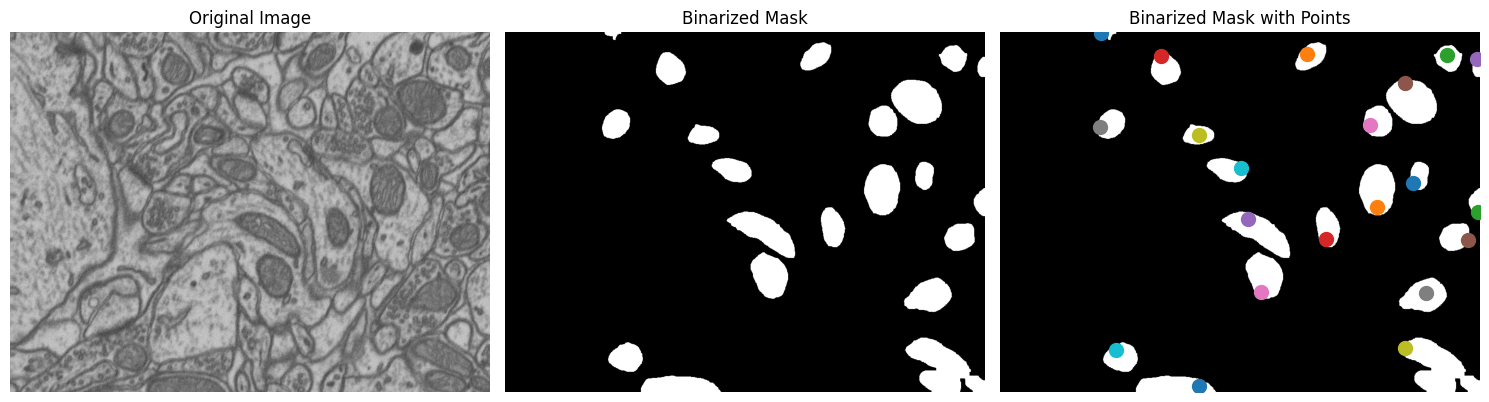

In [3]:
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

# 開始訓練

In [6]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

In [7]:
# Initialize scheduler
from torch import tensor


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
    with torch.cuda.amp.autocast():
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
        if image is None or mask is None or num_masks == 0:
            continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue

        if input_point.size == 0 or input_label.size == 0:
            continue

        predictor.set_image(image)
        mask_input, ucc, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        if ucc is None or labels is None or ucc.shape[0] == 0 or labels.shape[0] == 0:
            continue
        # print(ucc)
        # Loop through the tensor
        for i in range(ucc.shape[0]):
            # Extract a [1, 2, 256] slice
            uc = ucc[i:i+1, :, :]
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(uc, labels), boxes=None, masks=None,
            )

            batched_mode = uc.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05

            # Apply gradient accumulation
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

            if step % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                predictor.model.zero_grad()

            # Update scheduler
            scheduler.step()

        if step % 500 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        if step == 1:
            mean_iou = 0

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:
            print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

f:\github\segment-anything-2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:607.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ..\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ..\aten\src\ATen\native\transformers

Step 100:	 Accuracy (IoU) =  0.2297097416549149
Step 200:	 Accuracy (IoU) =  0.4320045138299686
Step 300:	 Accuracy (IoU) =  0.5108772773835516
Step 400:	 Accuracy (IoU) =  0.5305488190706177
Step 500:	 Accuracy (IoU) =  0.535929101456934
Step 600:	 Accuracy (IoU) =  0.5342476513484782
Step 700:	 Accuracy (IoU) =  0.5340202197049357


: 

# 開始推理

In [4]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [5]:
# Randomly select a test image from the test_data
import random


selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

print(mask_path)

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

org_mask = mask

# Generate random points for the input
num_samples = 2  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_2000_old.torch"
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "configs/sam2/sam2_hiera_l.yaml"
# Build net and load weights
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device="cuda"))
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# count lou


dataset\Lucchi++\Test_Out\121.png


f:\github\segment-anything-2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:607.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ..\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ..\aten\src\ATen\native\transformers

In [6]:
# Load the selected image and mask
image, mask_2 = read_image(image_path, mask_path)

# Build net and load weights from orignal SAM2
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor2 = SAM2ImagePredictor(sam2_model)

# Generate random points for the input
num_samples = 2
input_points = get_points(mask, num_samples)

# Perform inference and predict masks
# 用box(整個圖像)的形式輸入prompt
with torch.no_grad():
   predictor2.set_image(image)
   masks, scores, logits = predictor2.predict(
      point_coords=input_points,
      point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks_2 = np.array(masks[:, 0])
np_scores_2 = scores[:, 0]
sorted_masks_2 = np_masks_2[np.argsort(np_scores_2)][::-1]

# Initialize segmentation map and occupancy mask
seg_map2 = np.zeros_like(sorted_masks_2[0], dtype=np.uint8)
occupancy_mask_2 = np.zeros_like(sorted_masks_2[0], dtype=bool)
# Combine masks to create the final segmentation map
for i in range(sorted_masks_2.shape[0]):
   mask_2 = sorted_masks_2[i]
   if (mask_2 * occupancy_mask_2).sum() / mask_2.sum() > 0.15:
       continue

   mask_bool_2 = mask_2.astype(bool)
   mask_bool_2[occupancy_mask_2] = False  # Set overlapping areas to False in the mask
   seg_map2[mask_bool_2] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask_2[mask_bool_2] = True  # Update occupancy_mask


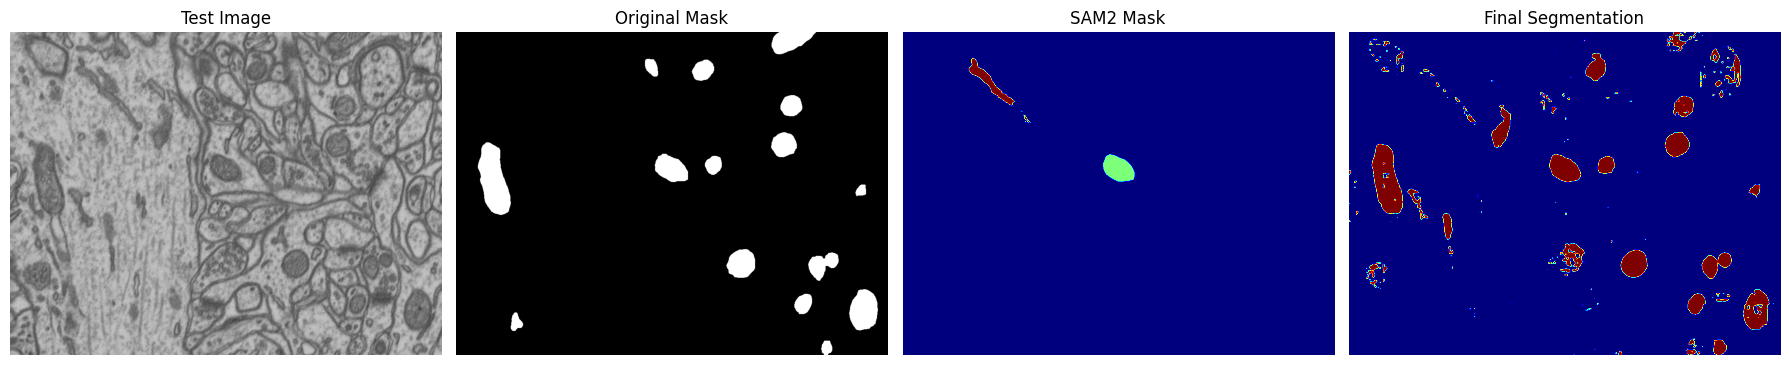

In [7]:

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask')
plt.imshow(org_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('SAM2 Mask')
plt.imshow(seg_map2, cmap='jet')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()